In [ ]:
# Install and import necessary packages and libraries
#%pip install numpy matplotlib scikit-learn torch torchvision torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ==============================
# ========== Data Loading and Preprocessing ===============
# ==============================

def load_and_preprocess_mnist(subset_fraction=0.1, val_fraction=0.2, batch_size=64, data_root='./data'):
    """
    Loads, preprocesses, and splits the MNIST dataset.

    Args:
        subset_fraction (float, optional): Fraction of the dataset to use.
        val_fraction (float, optional): Fraction of the training set to use for validation.
        batch_size (int, optional): Batch size for the DataLoaders. Defaults to 64.
        data_root (str, optional): Root directory for storing the data. Defaults to './data'.

    Returns:
        tuple: (train_loader, val_loader, test_loader) - DataLoaders for training, validation, and testing.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(root=data_root,
                          train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root=data_root,
                          train=False, download=True, transform=transform)

    # Subsample
    train_subset_size = int(len(train_dataset) * subset_fraction)
    test_subset_size = int(len(test_dataset) * subset_fraction)

    train_subset = Subset(train_dataset, list(range(train_subset_size)))
    test_subset = Subset(test_dataset, list(range(test_subset_size)))

    # Split train into train and val
    val_size = int(train_subset_size * val_fraction)
    train_size = train_subset_size - val_size

    train_data, val_data = random_split(train_subset, [train_size, val_size])

    # DataLoaders
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size,
                              shuffle=True)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size,
                            shuffle=False)
    test_loader = DataLoader(dataset=test_subset, batch_size=batch_size,
                             shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
"""# ==============================
# ========== Model Definition ===============
# ==============================

class LogisticRegression(nn.Module):
    """
    #Defines a simple Logistic Regression model for MNIST.
"""
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten image
        out = self.linear(x)
        return out"""

'\n    def __init__(self):\n        super(LogisticRegression, self).__init__()\n        self.linear = nn.Linear(28*28, 10)\n\n    def forward(self, x):\n        x = x.view(-1, 28*28)  # flatten image\n        out = self.linear(x)\n        return out'

In [ ]:
# ==============================
# ========== Model Definition ===============
# ==============================

class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 784)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
# ==============================
# ========== Gradient Variance Computation ===============
# ==============================

def compute_gradient_variance(model):
    """
    Computes variance of all parameter gradients in the model at the current training step.
    Returns the scalar variance value.
    """
    grad_list = []

    for param in model.parameters():
        if param.grad is not None:
            grad_list.append(param.grad.detach().view(-1))

    if not grad_list:
        return None

    grads = torch.cat(grad_list)
    return torch.var(grads).item()

In [ ]:
# ==============================
# ========== Training and Evaluation Functions ===============
# ==============================

def train(model, loader, criterion, optimizer, technique, num_epochs):
    """
    Trains the model for the specified number of epochs.

    Args:
        model (torch.nn.Module): The model to train.
        loader (torch.utils.data.DataLoader): The training data loader.
        criterion (torch.nn.modules.loss._Loss): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        num_epochs (int, optional): Number of epochs to train. Defaults to 10.

    Returns:
        tuple: (epoch_losses, grad_variances, epoch_val_accuracies) - Lists of training loss, gradient variance, and validation accuracy per epoch.
    """
    model.train()
    epoch_losses = []
    grad_variances = []
    epoch_val_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            if technique == 'spider':
              optimizer.step(loader, device)
            else:
              optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = total_loss / len(loader)
        epoch_losses.append(epoch_loss)

        # Compute gradient variance after last batch of epoch
        grad_var = compute_gradient_variance(model)
        grad_variances.append(grad_var)

        val_accuracy = evaluate(model, val_loader)
        epoch_val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, '
              f'Train Accuracy: {100 * correct/total:.2f}%, Grad Var: {grad_var:.6f}')

    return epoch_losses, grad_variances, epoch_val_accuracies


def evaluate(model, loader):
    """
    Evaluates the model on the given data loader.

    Args:
        model (torch.nn.Module): The model to evaluate.
        loader (torch.utils.data.DataLoader): The data loader.

    Returns:
        float: The accuracy on the data loader.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
# ==============================
# ========== SPIDER Optimizers ===============
# ==============================

class SPIDERFirstOrderOptimizer:
    """
    Implements the SPIDER (Stochastic Path-Integrated Differential Estimator)
    optimizer for a first-order stochastic method, similar to SPIDER-SFO.
    """
    def __init__(self, model, lr=0.005, large_batch_size=2048, small_batch_size=64, update_freq=5):
        """
        Initializes the SPIDERFirstOrderOptimizer.

        Args:
            model (torch.nn.Module): The neural network model to optimize.
            lr (float, optional): The learning rate for the parameter update. Defaults to 0.005.
            large_batch_size (int, optional): The batch size for the full gradient computation. Defaults to 2048.
            small_batch_size (int, optional): The batch size for the stochastic gradient difference computation. Defaults to 64.
            update_freq (int, optional): The frequency (in steps) at which to compute the full gradient.
                                         Corresponds to 'q' in Algorithm 1 of the SPIDER paper. Defaults to 5.
        """
        self.model = model
        self.lr = lr
        self.large_batch_size = large_batch_size
        self.small_batch_size = small_batch_size
        self.update_freq = update_freq
        self.v_k = None  # Stores the current estimate of the gradient
        self.prev_params = None  # Stores the model parameters at the last full gradient computation (x_{t-1} in the paper at the full grad step)
        self.step_counter = 0

    def _get_flat_params(self):
        """
        Flattens the parameters of the model into a single 1D tensor.
        """
        return torch.cat([param.data.view(-1) for param in self.model.parameters()])

    def _set_flat_params(self, flat_params):
        """
        Sets the parameters of the model from a flattened 1D tensor.
        """
        idx = 0
        for param in self.model.parameters():
            param_length = param.numel()
            param.data.copy_(flat_params[idx:idx+param_length].view_as(param))
            idx += param_length

    def _compute_gradients(self, data_loader, device):
        """
        Computes the full gradient.
        """
        self.model.zero_grad()
        total_samples = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = self.model(images)
            loss = F.cross_entropy(outputs, labels, reduction='sum')
            loss.backward()
            total_samples += labels.size(0)
        grads = torch.cat([param.grad.detach().view(-1) for param in self.model.parameters()])
        return grads / total_samples

    def zero_grad(self):
        """
        Clears the gradients of all optimized parameters.
        """
        self.model.zero_grad()

    def step(self, train_loader, device):
        """
        Performs a single optimization step using a SPIDER-like update rule
        (Algorithm 1 - SPIDER-SFO).
        """
        self.step_counter += 1

        # Algorithm 1: Step 2 (or initialization) - Compute full gradient periodically
        if self.step_counter % self.update_freq == 1 or self.v_k is None:
            large_batch_loader = DataLoader(
                train_loader.dataset, batch_size=self.large_batch_size, shuffle=True, drop_last=True
            )
            self.v_k = self._compute_gradients(large_batch_loader, device)
            self.prev_params = self._get_flat_params().detach().clone() # Store parameters at full gradient update
        else:
            # Algorithm 1: Step 3 - Recursive gradient update (SPIDER update)
            small_batch_loader = DataLoader(
                train_loader.dataset, batch_size=self.small_batch_size, shuffle=True, drop_last=True
            )
            small_batch_iter = iter(small_batch_loader)
            try:
                images1, labels1 = next(small_batch_iter) # Sample ξ_k
                images2, labels2 = next(small_batch_iter) # Sample ξ_{k-1}
                images1, labels1 = images1.to(device), labels1.to(device)
                images2, labels2 = images2.to(device), labels2.to(device)

                # Compute stochastic gradient at current parameters (∇f(x_k, ξ_k))
                self.model.zero_grad()
                outputs1 = self.model(images1)
                loss1 = F.cross_entropy(outputs1, labels1)
                loss1.backward()
                grad_current = torch.cat([param.grad.detach().view(-1) for param in self.model.parameters()])

                # Compute stochastic gradient at previous parameters (∇f(x_{k-1}, ξ_{k-1}))
                current_params = self._get_flat_params()
                self._set_flat_params(self.prev_params)
                self.model.zero_grad()
                outputs2 = self.model(images2)
                loss2 = F.cross_entropy(outputs2, labels2)
                loss2.backward()
                grad_prev = torch.cat([param.grad.detach().view(-1) for param in self.model.parameters()])
                self._set_flat_params(current_params)

                # Algorithm 1: Step 3 - Update gradient estimate: v_k = v_{k-1} + ∇f(x_k, ξ_k) - ∇f(x_{k-1}, ξ_k)
                self.v_k = self.v_k + grad_current - grad_prev
                self.prev_params = current_params.detach().clone() # Update stored previous parameters
            except StopIteration:
                print("Warning: DataLoader ran out of batches during SPIDER step.")

        # Algorithm 1: Step 4 - Apply parameter update (simplified with fixed learning rate)
        flat_params = self._get_flat_params()
        new_flat_params = flat_params - self.lr * self.v_k
        self._set_flat_params(new_flat_params)


In [ ]:
train_loader, val_loader, test_loader = load_and_preprocess_mnist()
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
# ==============================
# ========== Training with SPIDER-SFO (First-Order) ===============
# ==============================

print("\nTraining MLP Model with SPIDER-SFO...\n")
model_spider_fo = MLP().to(device)
spider_fo_config = {
    'lr': 0.01,
    'large_batch_size': 1024,
    'small_batch_size': 32,
    'update_freq': 5
}
spider_fo_optimizer = SPIDERFirstOrderOptimizer(model_spider_fo, **spider_fo_config)
spider_fo_losses, spider_fo_grad_variances, spider_fo_val_accuracies = train(model_spider_fo, train_loader, criterion, spider_fo_optimizer, technique = "spider", num_epochs=20)
test_accuracy_spider_fo = evaluate(model_spider_fo, test_loader)
print(f'Test Accuracy (SPIDER-SFO):', test_accuracy_spider_fo)


Training MLP Model with SPIDER-SFO...

Epoch [1/20], Loss: 1.7936, Train Accuracy: 48.40%, Grad Var: 0.000067
Epoch [2/20], Loss: 1.0719, Train Accuracy: 70.48%, Grad Var: 0.000078
Epoch [3/20], Loss: 0.7455, Train Accuracy: 79.12%, Grad Var: 0.000102
Epoch [4/20], Loss: 0.6203, Train Accuracy: 82.25%, Grad Var: 0.000022
Epoch [5/20], Loss: 0.5165, Train Accuracy: 85.19%, Grad Var: 0.000032
Epoch [6/20], Loss: 0.4636, Train Accuracy: 86.83%, Grad Var: 0.000038
Epoch [7/20], Loss: 0.4177, Train Accuracy: 88.71%, Grad Var: 0.000052
Epoch [8/20], Loss: 0.4125, Train Accuracy: 87.77%, Grad Var: 0.000014
Epoch [9/20], Loss: 0.3824, Train Accuracy: 88.81%, Grad Var: 0.000016
Epoch [10/20], Loss: 0.3698, Train Accuracy: 88.90%, Grad Var: 0.000091
Epoch [11/20], Loss: 0.3799, Train Accuracy: 88.46%, Grad Var: 0.000076
Epoch [12/20], Loss: 0.3702, Train Accuracy: 88.35%, Grad Var: 0.000017
Epoch [13/20], Loss: 0.3480, Train Accuracy: 89.73%, Grad Var: 0.000065
Epoch [14/20], Loss: 0.3392, Trai

In [ ]:
class STORMOptimizer(torch.optim.Optimizer):
    """
    Implements the STORM optimizer from the paper.
    """

    def __init__(self, params, lr=0.1, c=100.0, k=0.1, w=0.1):
        super(STORMOptimizer, self).__init__(params, {})
        defaults = dict(lr=lr, c=c, k=k, w=w, momentum={})
        for group in self.param_groups:
            group.update(defaults)


    def __setstate__(self, state):
        super(STORMOptimizer, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            c = group['c']
            k = group['k']
            w = group['w']
            momentum = group['momentum']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                param_state = self.state[p]

                # Initialize momentum
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = torch.zeros_like(p.data)
                    param_state['sum_sq_grad_norm'] = 0.0  # Initialize sum of squared gradient norms

                momentum_buffer = param_state['momentum_buffer']
                sum_sq_grad_norm = param_state['sum_sq_grad_norm']

                # Update sum of squared gradient norms
                sum_sq_grad_norm = sum_sq_grad_norm + torch.pow(torch.norm(grad), 2)
                param_state['sum_sq_grad_norm'] = sum_sq_grad_norm

                # Adaptive learning rate
                eta = k / (w + sum_sq_grad_norm) ** (1.0 / 3.0)

                # Calculate 'a'
                a = min(c * eta**2, 1.0)

                # Update momentum buffer
                momentum_buffer.mul_(1 - a).add_(grad, alpha=1).add_(momentum_buffer, alpha=- (1-a) )

                # Update parameters
                p.data.add_(momentum_buffer, alpha=-eta)

        return loss

In [ ]:
"""# ==============================
# ========== STORM Hyperparameter Tuning  ===============
# ==============================
model_storm = MLP().to(device)

best_hyperparams = {'k': None, 'w': None, 'c': None}
best_val_accuracy = 0.0

# --- Hyperparameter Tuning ---
# 1. Tune Learning Rate (k)
k_values = [0.0001, 0.001, 0.01, 0.1]
w = 1.0  # Keep w and c constant initially
c = 0.1

print("\n--- Tuning Learning Rate (k) ---")
for k in k_values:
    print(f"\nTrying k = {k}")
    model_storm.load_state_dict(model_storm.state_dict()) # Reset model weights
    optimizer_storm = STORMOptimizer(model_storm.parameters(), k=k, w=w, c=c)
    storm_losses, storm_grad_variances, storm_val_accuracies = train(
        model_storm, train_loader, criterion, optimizer_storm, technique = "storm", num_epochs=10
    )
    test_accuracy_storm = evaluate(model_storm, test_loader)
    val_accuracy = evaluate(model_storm, val_loader)  # Evaluate on validation set
    print(f'Test Accuracy (STORM, k={k}):', test_accuracy_storm)
    print(f'Val Accuracy (STORM, k={k}):', val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_hyperparams['k'] = k

# 2. Tune Adaptive Learning Rate Control (w) - Use best k from above

k = best_hyperparams['k']
w_values = [0.1, 1.0, 10.0, 100.0]
c = 0.1
best_val_accuracy = 0.0
print("\n--- Tuning Adaptive Learning Rate (w) ---")
for w in w_values:
    print(f"\nTrying w = {w}")
    model_storm.load_state_dict(model_storm.state_dict()) # Reset model weights
    optimizer_storm = STORMOptimizer(model_storm.parameters(), k=k, w=w, c=c)
    storm_losses, storm_grad_variances, storm_val_accuracies = train(
        model_storm, train_loader, criterion, optimizer_storm, technique = "storm", num_epochs=10
    )
    test_accuracy_storm = evaluate(model_storm, test_loader)
    val_accuracy = evaluate(model_storm, val_loader)
    print(f'Test Accuracy (STORM, k={k}, w={w}):', test_accuracy_storm)
    print(f'Val Accuracy (STORM, k={k}, w={w}):', val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_hyperparams['w'] = w

# 3. Tune Momentum (c) - Use best k and w from above
k = best_hyperparams['k']
w = best_hyperparams['w']
c_values = [0.001, 0.01, 0.1, 1.0]
best_val_accuracy = 0.0

print("\n--- Tuning Momentum (c) ---")
for c in c_values:
    print(f"\nTrying c = {c}")
    model_storm.load_state_dict(model_storm.state_dict()) # Reset model weights
    optimizer_storm = STORMOptimizer(model_storm.parameters(), k=k, w=w, c=c)
    storm_losses, storm_grad_variances, storm_val_accuracies = train(
        model_storm, train_loader, criterion, optimizer_storm, technique = "storm", num_epochs=10
    )
    test_accuracy_storm = evaluate(model_storm, test_loader)
    val_accuracy = evaluate(model_storm, val_loader)
    print(f'Test Accuracy (STORM, k={k}, w={w}, c={c}):', test_accuracy_storm)
    print(f'Val Accuracy (STORM, k={k}, w={w}, c={c}):', val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_hyperparams['c'] = c

print("\n--- Best Hyperparameters ---")
print(f"Best k: {best_hyperparams['k']}")
print(f"Best w: {best_hyperparams['w']}")
print(f"Best c: {best_hyperparams['c']}")
print(f"Best Validation Accuracy: {best_val_accuracy}")
"""

'# ==============================\n# ========== STORM Hyperparameter Tuning  ===============\n# ==============================\nmodel_storm = MLP().to(device)\n\nbest_hyperparams = {\'k\': None, \'w\': None, \'c\': None}\nbest_val_accuracy = 0.0\n\n# --- Hyperparameter Tuning ---\n# 1. Tune Learning Rate (k)\nk_values = [0.0001, 0.001, 0.01, 0.1]\nw = 1.0  # Keep w and c constant initially\nc = 0.1\n\nprint("\n--- Tuning Learning Rate (k) ---")\nfor k in k_values:\n    print(f"\nTrying k = {k}")\n    model_storm.load_state_dict(model_storm.state_dict()) # Reset model weights\n    optimizer_storm = STORMOptimizer(model_storm.parameters(), k=k, w=w, c=c)\n    storm_losses, storm_grad_variances, storm_val_accuracies = train(\n        model_storm, train_loader, criterion, optimizer_storm, technique = "storm", num_epochs=10\n    )\n    test_accuracy_storm = evaluate(model_storm, test_loader)\n    val_accuracy = evaluate(model_storm, val_loader)  # Evaluate on validation set\n    print(f\'Te

In [ ]:
# ==============================
# ========== Training with STORM ===============
# ==============================

# --- Use Best Hyperparameters from Tuning ---
#best_k = best_hyperparams['k']
#best_w = best_hyperparams['w']
#best_c = best_hyperparams['c']

print("\n--- Training with Best Hyperparameters ---")
#print(f"k: {best_k}, w: {best_w}, c: {best_c}")
model_storm = MLP().to(device)
optimizer_storm = STORMOptimizer(model_storm.parameters(), k=0.1, w=10, c=10)
storm_losses, storm_grad_variances, storm_val_accuracies = train(model_storm, train_loader, criterion, optimizer_storm, technique = "storm", num_epochs=80)
test_accuracy_storm = evaluate(model_storm, test_loader)
print(f'Test Accuracy (STORM, Best Hyperparameters):', test_accuracy_storm)


--- Training with Best Hyperparameters ---
Epoch [1/80], Loss: 2.2900, Train Accuracy: 14.48%, Grad Var: 0.000042
Epoch [2/80], Loss: 2.2795, Train Accuracy: 15.50%, Grad Var: 0.000031
Epoch [3/80], Loss: 2.2748, Train Accuracy: 16.04%, Grad Var: 0.000034
Epoch [4/80], Loss: 2.2716, Train Accuracy: 16.50%, Grad Var: 0.000036
Epoch [5/80], Loss: 2.2691, Train Accuracy: 16.79%, Grad Var: 0.000038
Epoch [6/80], Loss: 2.2671, Train Accuracy: 16.98%, Grad Var: 0.000049
Epoch [7/80], Loss: 2.2654, Train Accuracy: 17.12%, Grad Var: 0.000038
Epoch [8/80], Loss: 2.2639, Train Accuracy: 17.38%, Grad Var: 0.000039
Epoch [9/80], Loss: 2.2626, Train Accuracy: 17.58%, Grad Var: 0.000034
Epoch [10/80], Loss: 2.2614, Train Accuracy: 17.73%, Grad Var: 0.000037
Epoch [11/80], Loss: 2.2604, Train Accuracy: 18.00%, Grad Var: 0.000035
Epoch [12/80], Loss: 2.2594, Train Accuracy: 18.21%, Grad Var: 0.000034
Epoch [13/80], Loss: 2.2585, Train Accuracy: 18.42%, Grad Var: 0.000036
Epoch [14/80], Loss: 2.2577, 

In [ ]:
# ==============================
# ========== SGD ===============
# ==============================

print("\nTraining MLP MOdel with SGD...\n")
model_sgd = MLP().to(device)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
sgd_losses, sgd_grad_variances, sgd_val_accuracies = train(
    model_sgd, train_loader, criterion, optimizer_sgd,
    technique = "sgd", num_epochs=10
)
test_accuracy_sgd = evaluate(model_sgd, test_loader)
print(f'Test Accuracy (SGD):', test_accuracy_sgd)


Training MLP MOdel with SGD...

Epoch [1/10], Loss: 1.7387, Train Accuracy: 58.02%, Grad Var: 0.000033
Epoch [2/10], Loss: 0.9295, Train Accuracy: 80.81%, Grad Var: 0.000022
Epoch [3/10], Loss: 0.6297, Train Accuracy: 86.00%, Grad Var: 0.000013
Epoch [4/10], Loss: 0.5024, Train Accuracy: 88.17%, Grad Var: 0.000018
Epoch [5/10], Loss: 0.4330, Train Accuracy: 89.10%, Grad Var: 0.000016
Epoch [6/10], Loss: 0.3889, Train Accuracy: 90.40%, Grad Var: 0.000016
Epoch [7/10], Loss: 0.3575, Train Accuracy: 90.75%, Grad Var: 0.000017
Epoch [8/10], Loss: 0.3340, Train Accuracy: 91.02%, Grad Var: 0.000011
Epoch [9/10], Loss: 0.3152, Train Accuracy: 91.83%, Grad Var: 0.000015
Epoch [10/10], Loss: 0.3002, Train Accuracy: 91.94%, Grad Var: 0.000023
Test Accuracy (SGD): 88.1


In [ ]:
# ==============================
# ========== Adam ==============
# ==============================

print("\nTraining MLP with Adam...\n")
model_adam = MLP().to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
adam_losses, adam_grad_variances, adam_val_accuracies = train(
    model_adam, train_loader, criterion, optimizer_adam,
    technique = "adam", num_epochs=10
)
test_accuracy_adam = evaluate(model_adam, test_loader)
print(f'Test Accuracy (Adam):', test_accuracy_adam)


Training MLP with Adam...

Epoch [1/10], Loss: 0.6755, Train Accuracy: 81.94%, Grad Var: 0.000031
Epoch [2/10], Loss: 0.2931, Train Accuracy: 91.65%, Grad Var: 0.000015
Epoch [3/10], Loss: 0.2196, Train Accuracy: 93.96%, Grad Var: 0.000022
Epoch [4/10], Loss: 0.1735, Train Accuracy: 95.50%, Grad Var: 0.000004
Epoch [5/10], Loss: 0.1381, Train Accuracy: 96.08%, Grad Var: 0.000013
Epoch [6/10], Loss: 0.1113, Train Accuracy: 97.42%, Grad Var: 0.000002
Epoch [7/10], Loss: 0.0901, Train Accuracy: 97.79%, Grad Var: 0.000005
Epoch [8/10], Loss: 0.0745, Train Accuracy: 98.50%, Grad Var: 0.000008
Epoch [9/10], Loss: 0.0585, Train Accuracy: 98.77%, Grad Var: 0.000002
Epoch [10/10], Loss: 0.0437, Train Accuracy: 99.35%, Grad Var: 0.000003
Test Accuracy (Adam): 92.7


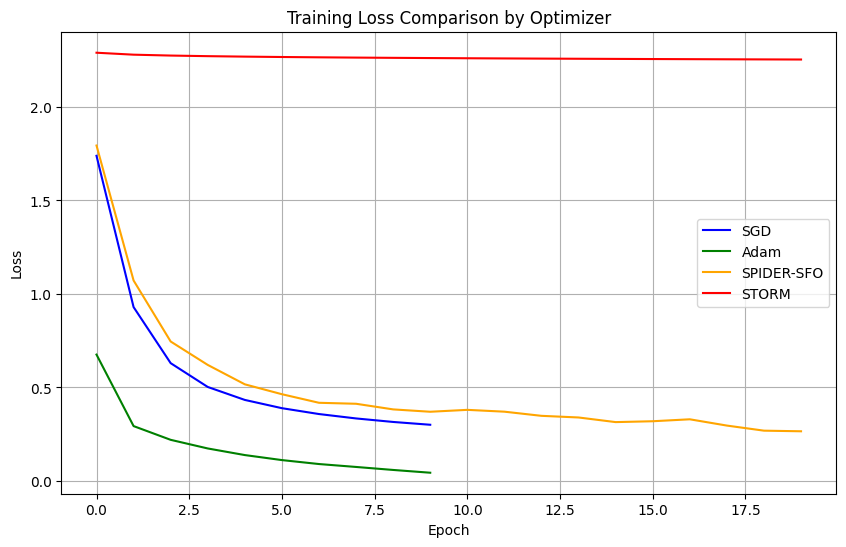

In [ ]:
# -------------------------------
# Plot Training Loss per Epoch
# -------------------------------

plt.figure(figsize=(10, 6))

# Plot all optimizers on the same plot
plt.plot(sgd_losses, label="SGD", color='blue')
plt.plot(adam_losses, label="Adam", color='green')
plt.plot(spider_fo_losses, label="SPIDER-SFO", color='orange')
plt.plot(storm_losses[:20], label="STORM", color='red')

# Set titles and labels
plt.title("Training Loss Comparison by Optimizer")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

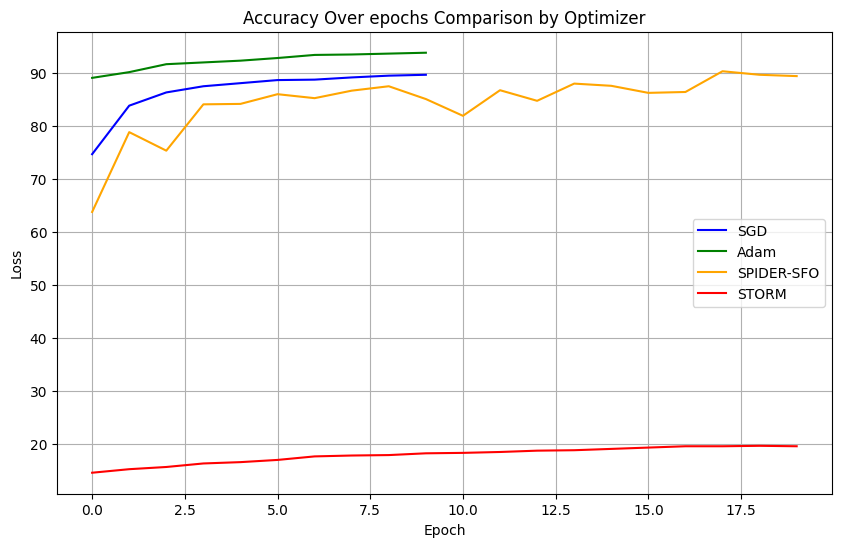

In [ ]:
# -------------------------------
# Plot Accuracy over time
# -------------------------------

plt.figure(figsize=(10, 6))

# Plot all optimizers on the same plot
plt.plot(sgd_val_accuracies, label="SGD", color='blue')
plt.plot(adam_val_accuracies, label="Adam", color='green')
plt.plot(spider_fo_val_accuracies, label="SPIDER-SFO", color='orange')
plt.plot(storm_val_accuracies[:20], label="STORM", color='red')

# Set titles and labels
plt.title("Accuracy Over epochs Comparison by Optimizer")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

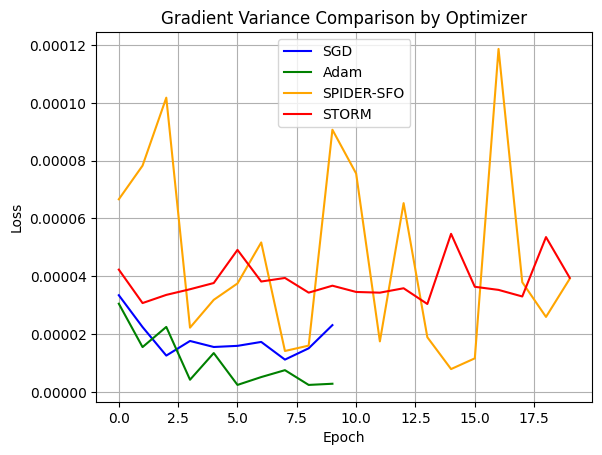

In [ ]:
# -------------------------------
# Plot Gradient Variance over time
# -------------------------------

# Plot all optimizers on the same plot
plt.plot(sgd_grad_variances, label="SGD", color='blue')
plt.plot(adam_grad_variances, label="Adam", color='green')
plt.plot(spider_fo_grad_variances, label="SPIDER-SFO", color='orange')
plt.plot(storm_grad_variances[:20], label="STORM", color='red')

# Set titles and labels
plt.title("Gradient Variance Comparison by Optimizer")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

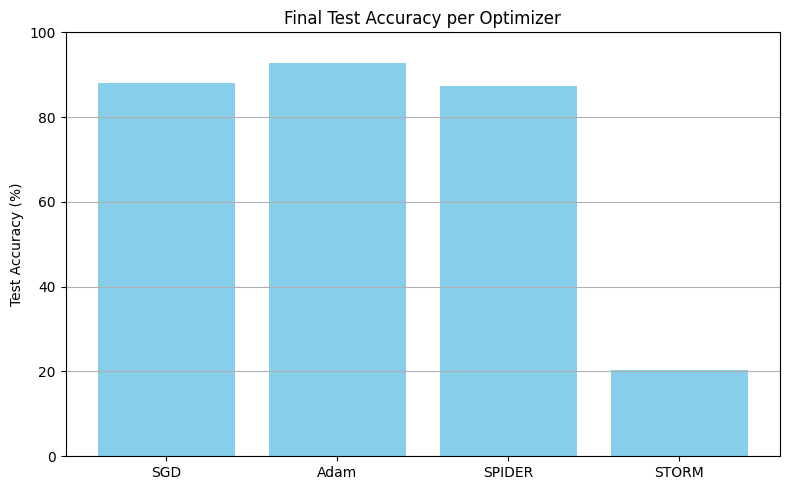

In [ ]:
# -------------------------------
# Plot Final Test Accuracy
# -------------------------------
optimizers = ["SGD", "Adam", "SPIDER", "STORM"]
accuracies = [test_accuracy_sgd, test_accuracy_adam,test_accuracy_spider_fo,test_accuracy_storm]


plt.figure(figsize=(8, 5))
plt.bar(optimizers, accuracies, color='skyblue')
plt.ylabel("Test Accuracy (%)")
plt.title("Final Test Accuracy per Optimizer")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()